In [2]:
#%% [Cell 1: Imports and Environment Setup]
"""
In this cell, we import all necessary libraries and configure our plotting and warning settings.
We use NumPy for numerical operations, matplotlib for plotting, and scikit-learn’s GaussianProcessRegressor for our surrogate model.
Seaborn is used for additional plot styling.
"""

'\nIn this cell, we import all necessary libraries and configure our plotting and warning settings.\nWe use NumPy for numerical operations, matplotlib for plotting, and scikit-learn’s GaussianProcessRegressor for our surrogate model.\nSeaborn is used for additional plot styling.\n'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import copy

# Ignore warnings to avoid clutter in our outputs
warnings.filterwarnings("ignore")

# Set a nice plotting style
sns.set(style="whitegrid", context="notebook")

# Import Gaussian Process tools from scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import norm

# Print a starting message
print("Active Learning for Materials Discovery: Environment setup complete.")

Active Learning for Materials Discovery: Environment setup complete.


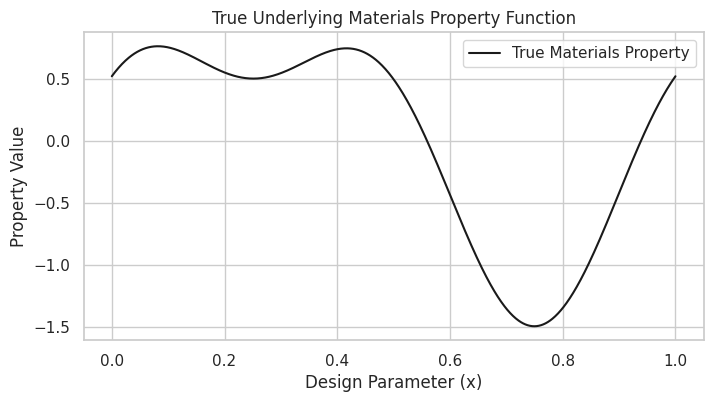

Defined the true materials property function and plotted it.


In [6]:
#%% [Cell 2: Define the True Materials Property Function]
"""
Here, we define a synthetic function that represents the underlying relationship between a materials design parameter (e.g., composition)
and its corresponding property (e.g., strength, conductivity, etc.). This function simulates the “true” behavior of our system.
We will assume the domain is one-dimensional for simplicity.
"""

def true_materials_property(x):
    """
    Simulated true function for a materials property.
    The function is non-linear and multimodal to mimic complex behavior in real materials discovery.
    Input:
        x : array-like, design parameter(s) (e.g., composition fraction)
    Output:
        y : simulated property value(s)
    """
    # A combination of sinusoidal and polynomial behavior:
    y = np.sin(2 * np.pi * x) + 0.5 * np.cos(4 * np.pi * x) + 0.1 * (x - 0.5)**2
    return y

# Create a dense grid of x values for plotting the true function
x_dense = np.linspace(0, 1, 1000)
y_dense = true_materials_property(x_dense)

# Plot the true function for reference
plt.figure(figsize=(8, 4))
plt.plot(x_dense, y_dense, 'k-', label="True Materials Property")
plt.title("True Underlying Materials Property Function")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Property Value")
plt.legend()
plt.show()

print("Defined the true materials property function and plotted it.")

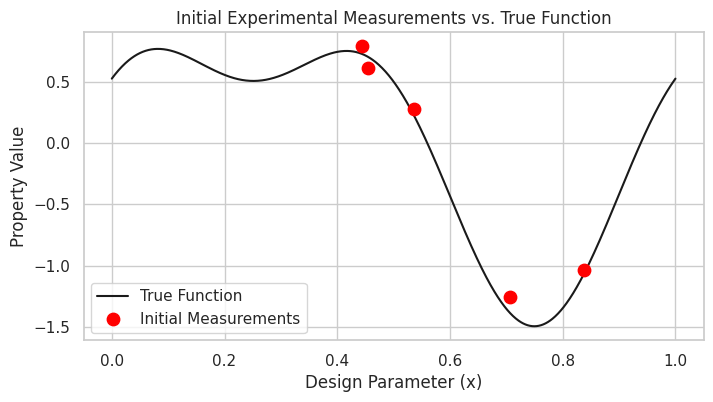

Initial experimental data generated and plotted.


In [7]:
#%% [Cell 3: Simulate Experimental Measurements]
"""
Define a function to simulate noisy experimental measurements.
In a real laboratory, measured properties are subject to noise. Here, we simulate that with Gaussian noise.
"""

def simulate_measurement(x, noise_std=0.1):
    """
    Simulate an experimental measurement of the materials property.
    This function adds Gaussian noise to the true function value.
    Inputs:
        x : float or array-like, design parameter(s)
        noise_std : standard deviation of the Gaussian noise (default 0.1)
    Output:
        y_noisy : noisy measurement(s)
    """
    true_value = true_materials_property(x)
    noise = np.random.normal(0, noise_std, size=np.shape(x))
    return true_value + noise

# Generate some initial experimental measurements (sparse sampling)
np.random.seed(42)
initial_indices = np.random.choice(np.linspace(0, 1, 100), size=5, replace=False)
X_initial = np.sort(initial_indices)
Y_initial = simulate_measurement(X_initial)

# Plot the initial experimental data against the true function
plt.figure(figsize=(8, 4))
plt.plot(x_dense, y_dense, 'k-', label="True Function")
plt.scatter(X_initial, Y_initial, c='red', s=80, label="Initial Measurements", zorder=5)
plt.title("Initial Experimental Measurements vs. True Function")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Property Value")
plt.legend()
plt.show()

print("Initial experimental data generated and plotted.")

In [8]:
#%% [Cell 4: Define the Surrogate Model (Gaussian Process)]
"""
We now define our surrogate model using Gaussian Process Regression (GPR). GPR is widely used in active learning due to its
ability to quantify uncertainty. Here, we set up a kernel that combines a constant kernel, a Matérn kernel, and a white noise kernel.
"""

# Define the kernel with hyperparameters
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e1))

# Initialize the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.0, normalize_y=True)

# Fit the GPR model on the initial data
gpr.fit(X_initial.reshape(-1, 1), Y_initial)

# Print the optimized kernel parameters
print("Optimized kernel parameters after initial training:")
print(gpr.kernel_)


Optimized kernel parameters after initial training:
1.06**2 * Matern(length_scale=0.215, nu=1.5) + WhiteKernel(noise_level=0.014)


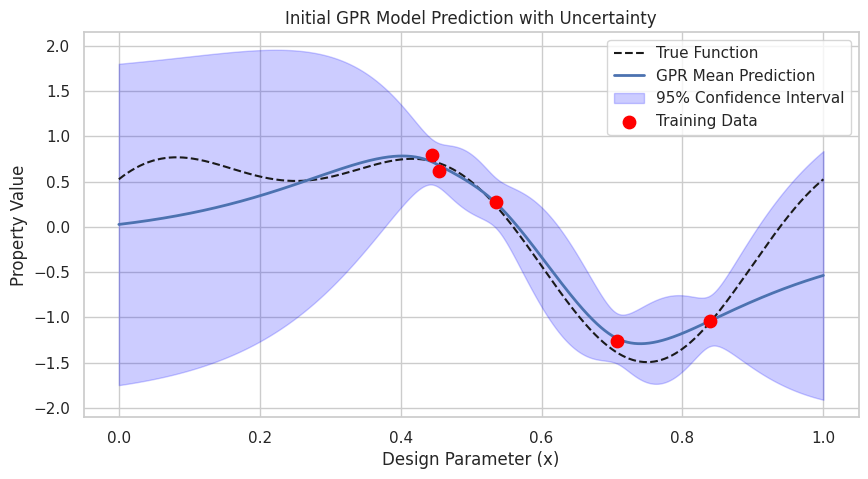

Displayed initial surrogate model predictions and uncertainty bounds.


In [9]:
#%% [Cell 5: Visualize the Surrogate Model Predictions and Uncertainty]
"""
This cell uses our trained surrogate model to predict the materials property over the entire domain.
We then plot the mean prediction along with the uncertainty (confidence intervals) provided by the Gaussian Process.
"""

def plot_gpr_prediction(model, X_train, Y_train, title="GPR Prediction with Uncertainty"):
    """
    Plot the Gaussian Process Regression predictions and confidence intervals.
    Inputs:
        model: trained GPR model
        X_train: training input data
        Y_train: training target data
        title: plot title (optional)
    """
    # Create a dense grid for predictions
    X_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
    Y_mean, Y_std = model.predict(X_plot, return_std=True)

    plt.figure(figsize=(10, 5))
    plt.plot(X_plot, true_materials_property(X_plot), 'k--', label="True Function", linewidth=1.5)
    plt.plot(X_plot, Y_mean, 'b-', label="GPR Mean Prediction", linewidth=2)
    plt.fill_between(X_plot.ravel(), Y_mean - 1.96*Y_std, Y_mean + 1.96*Y_std, alpha=0.2, color='blue', label="95% Confidence Interval")
    plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
    plt.title(title)
    plt.xlabel("Design Parameter (x)")
    plt.ylabel("Property Value")
    plt.legend(loc="upper right")
    plt.show()

# Plot the current GPR prediction with the initial training data
plot_gpr_prediction(gpr, X_initial, Y_initial, title="Initial GPR Model Prediction with Uncertainty")

print("Displayed initial surrogate model predictions and uncertainty bounds.")

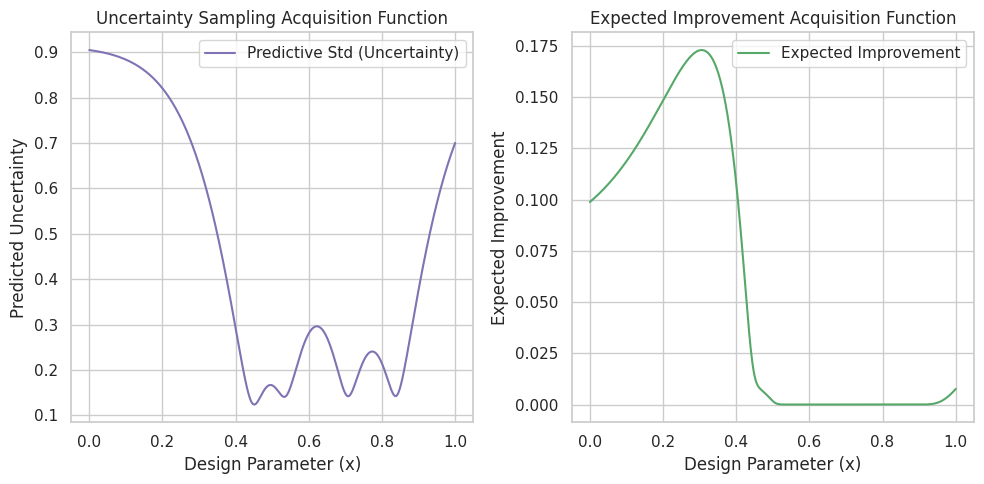

Acquisition functions defined and visualized.


In [16]:
#%% [Cell 6: Define Acquisition Functions]
"""
We now define two acquisition functions for our active learning strategy:
1. Uncertainty Sampling: Selects the point with the highest predictive standard deviation.
2. Expected Improvement (EI): Balances exploration and exploitation by considering both the predicted mean and uncertainty.

These functions will guide the selection of the next experiment.
"""

def acquisition_uncertainty(model, X_candidates):
    """
    Uncertainty Sampling Acquisition Function.
    Inputs:
        model: trained GPR model
        X_candidates: candidate points for experimentation
    Output:
        uncertainties: predicted standard deviation at each candidate point
    """
    _, std = model.predict(X_candidates, return_std=True)
    return std

def acquisition_expected_improvement(model, X_candidates, Y_best, xi=0.01):
    """
    Expected Improvement (EI) Acquisition Function.
    This function calculates the expected improvement over the best observed value.
    Inputs:
        model: trained GPR model
        X_candidates: candidate points for experimentation (2D array)
        Y_best: best observed value so far (scalar)
        xi: exploration parameter (default 0.01)
    Output:
        EI: expected improvement at each candidate point (array)
    """
    # Predict the mean and standard deviation for candidate points
    mu, sigma = model.predict(X_candidates, return_std=True)
    # sigma = sigma.reshape(-1, 1) # This line is the issue, it results in the wrong dimension for sigma

    # Avoid division by zero
    with np.errstate(divide='warn'):
        improvement = mu - Y_best - xi
        # Reshape the improvement to have the same dimension as sigma (broadcasting will do this for us)
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0  # Replace zeros for numerical stability
    return ei # Do not ravel the returned value to maintain 2D shape for consistency

# Test the acquisition functions on a candidate grid
X_candidates = np.linspace(0, 1, 1000).reshape(-1, 1)
uncertainties = acquisition_uncertainty(gpr, X_candidates)
Y_best = np.max(Y_initial)
EI = acquisition_expected_improvement(gpr, X_candidates, Y_best)

# Reshape EI to match the dimensions of X_candidates for plotting
EI = EI.reshape(-1, 1)  # or EI.reshape(X_candidates.shape)

# Plot the acquisition functions for visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(X_candidates, uncertainties, 'm-', label="Predictive Std (Uncertainty)")
plt.title("Uncertainty Sampling Acquisition Function")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Predicted Uncertainty")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X_candidates, EI, 'g-', label="Expected Improvement") # EI is now reshaped
plt.title("Expected Improvement Acquisition Function")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Expected Improvement")
plt.legend()

plt.tight_layout()
plt.show()

print("Acquisition functions defined and visualized.")

In [17]:
#%% [Cell 7: Active Learning Loop – Setup]
"""
In this cell, we initialize our active learning loop. We define:
- The maximum number of active learning iterations.
- A copy of the initial training data that will be updated as new experiments are selected.
- Lists to store the history of training data size and best observed property.
We also prepare a figure to visualize the evolution of the surrogate model.
"""

# Maximum number of iterations for the active learning loop
n_iterations = 20

# Copy initial training data
X_train = X_initial.reshape(-1, 1)
Y_train = Y_initial

# Lists to keep track of progress
training_data_sizes = [len(X_train)]
best_observed = [np.max(Y_train)]

# Create a candidate pool for selecting new experiments
X_pool = np.linspace(0, 1, 1000).reshape(-1, 1)

print("Starting active learning loop with {} iterations.".format(n_iterations))

Starting active learning loop with 20 iterations.



Iteration 1 of Active Learning
  Trained GPR on 5 data points.
  Selected next experiment at x = 0.3053 with EI = 0.1731
  New experimental measurement: y = 0.6197


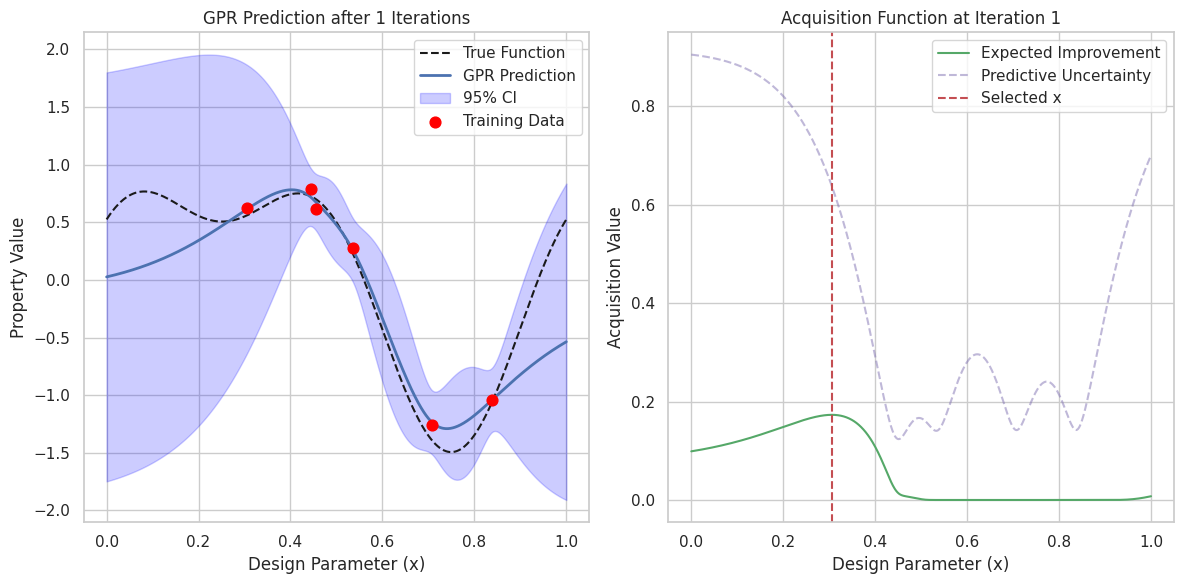


Iteration 2 of Active Learning
  Trained GPR on 6 data points.
  Selected next experiment at x = 0.0000 with EI = 0.0926
  New experimental measurement: y = 0.4153


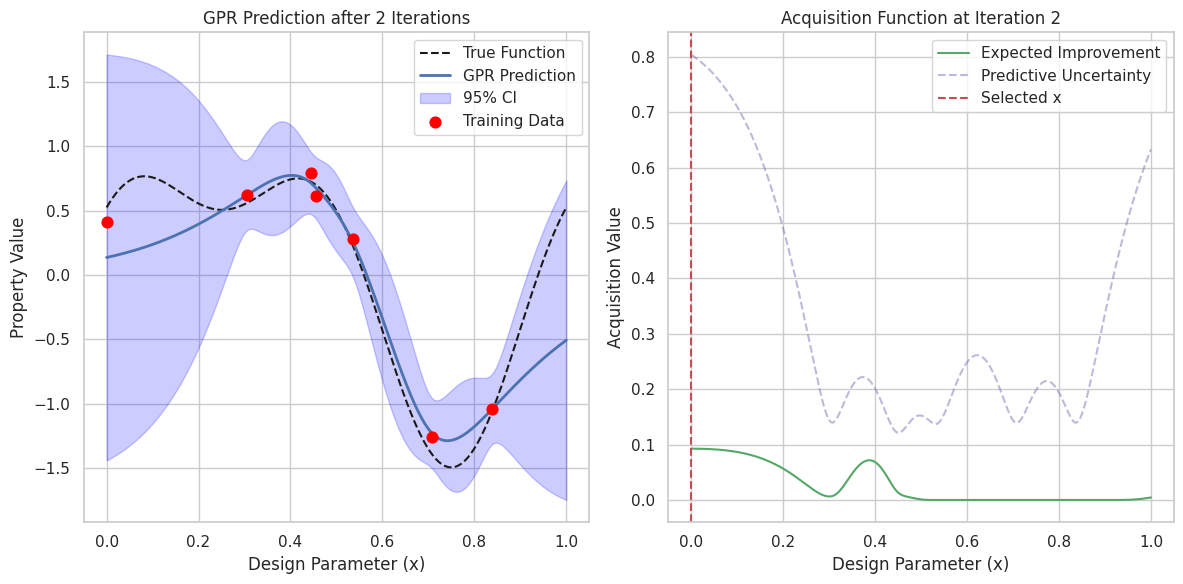


Iteration 3 of Active Learning
  Trained GPR on 7 data points.
  Selected next experiment at x = 0.3884 with EI = 0.0642
  New experimental measurement: y = 0.6619


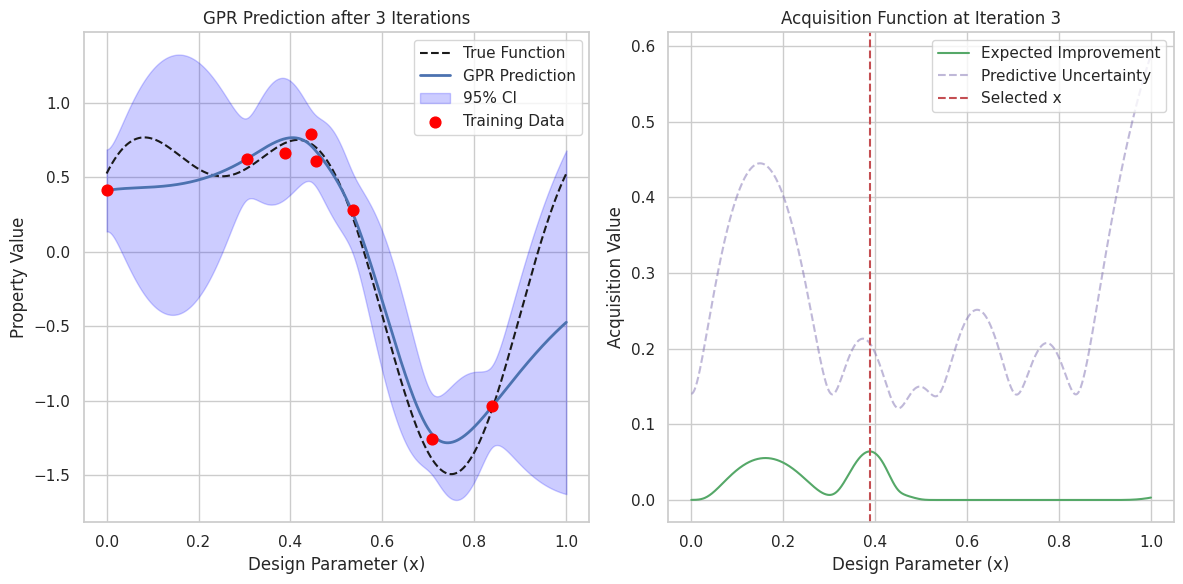


Iteration 4 of Active Learning
  Trained GPR on 8 data points.
  Selected next experiment at x = 0.1642 with EI = 0.0517
  New experimental measurement: y = 0.7695


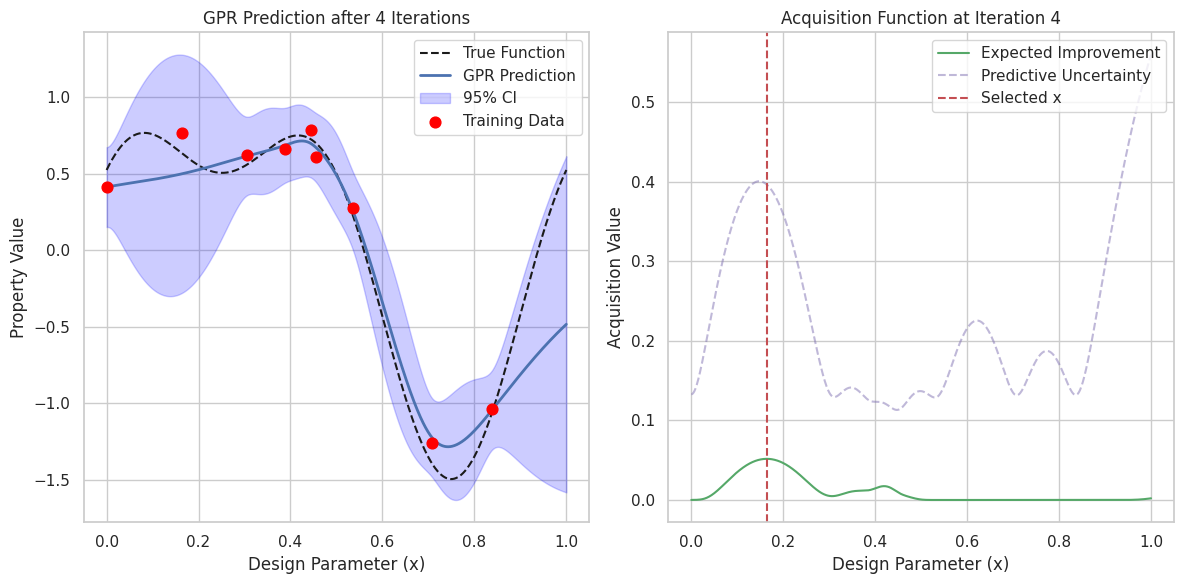


Iteration 5 of Active Learning
  Trained GPR on 9 data points.
  Selected next experiment at x = 0.2082 with EI = 0.0400
  New experimental measurement: y = 0.6588


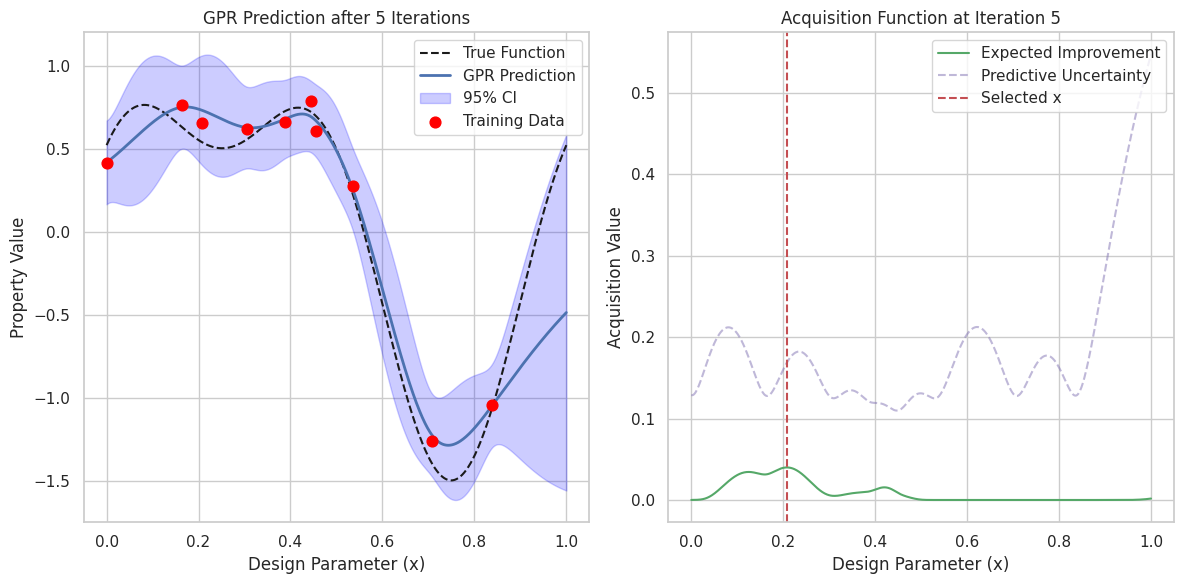


Iteration 6 of Active Learning
  Trained GPR on 10 data points.
  Selected next experiment at x = 0.1211 with EI = 0.0325
  New experimental measurement: y = 0.5292


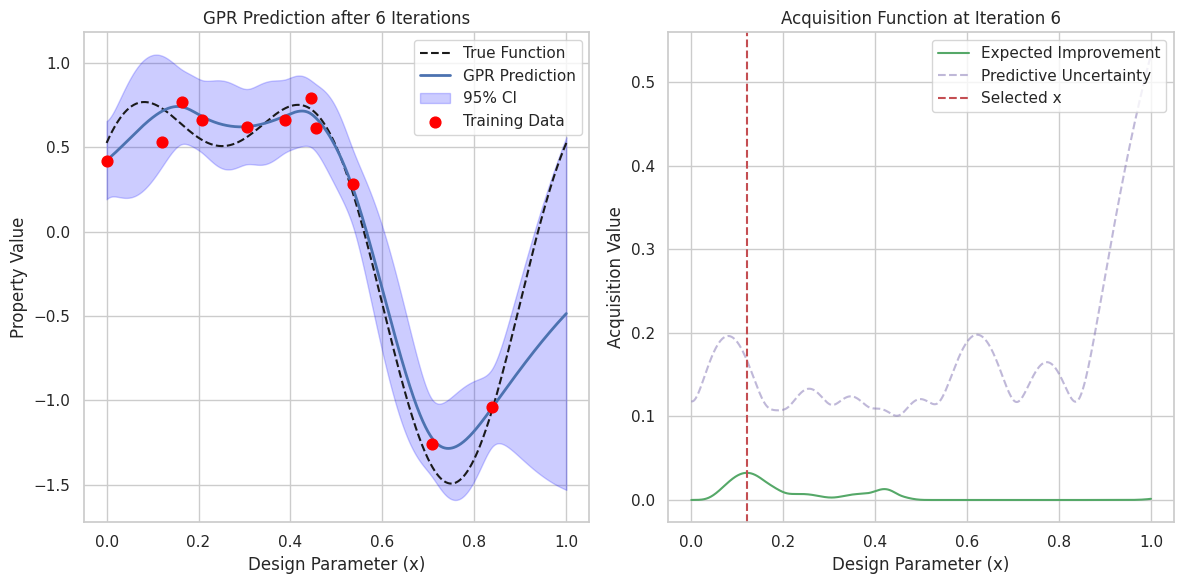


Iteration 7 of Active Learning
  Trained GPR on 11 data points.
  Selected next experiment at x = 0.4184 with EI = 0.0151
  New experimental measurement: y = 0.7932


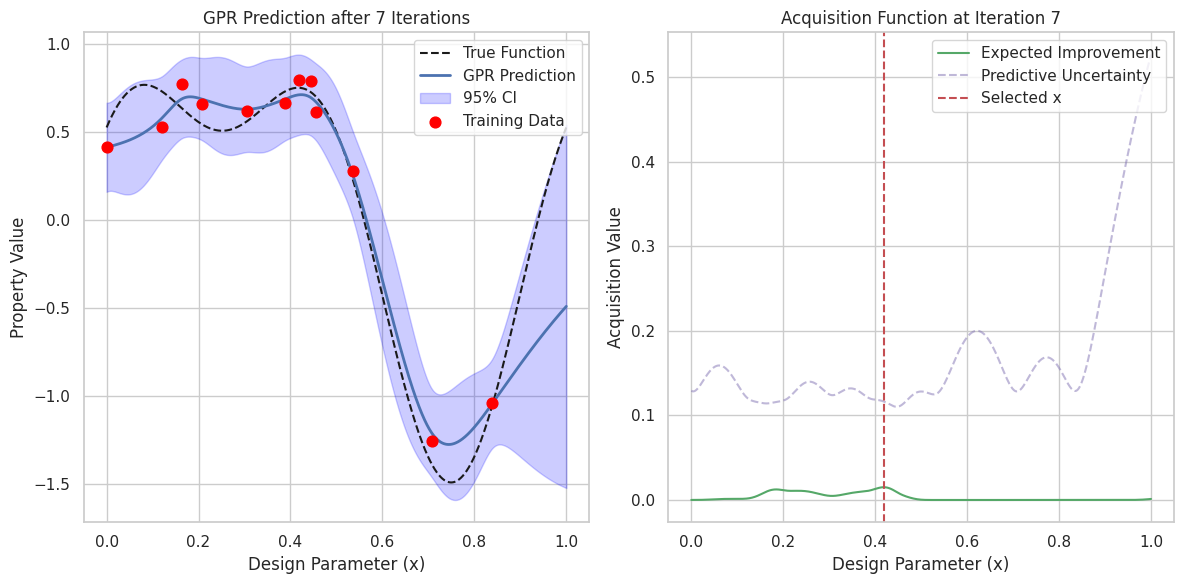


Iteration 8 of Active Learning
  Trained GPR on 12 data points.
  Selected next experiment at x = 0.4194 with EI = 0.0169
  New experimental measurement: y = 0.8677


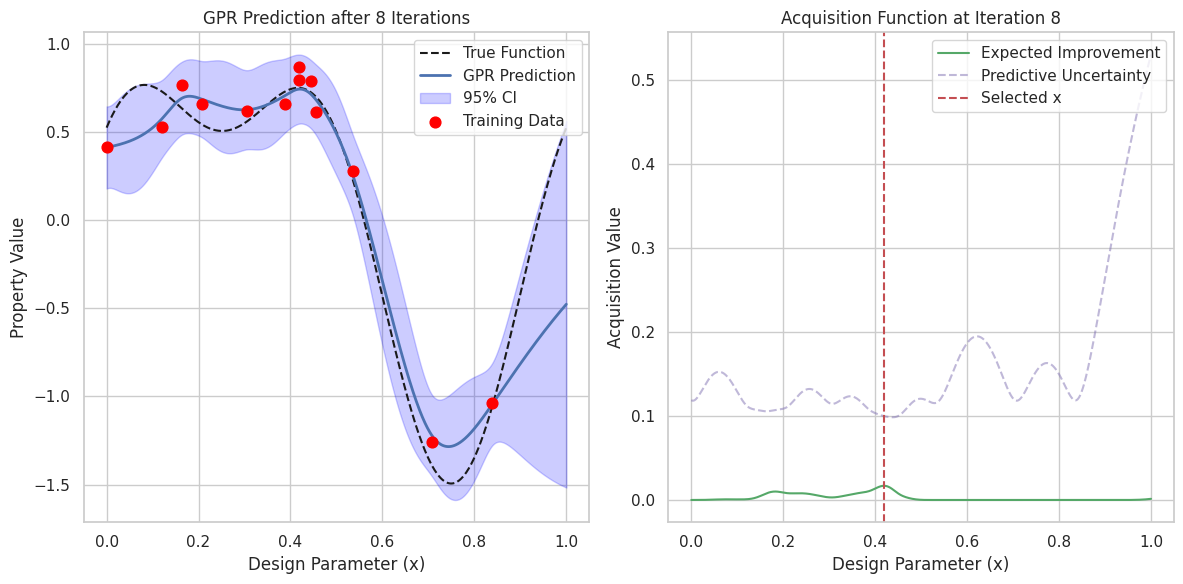


Iteration 9 of Active Learning
  Trained GPR on 13 data points.
  Selected next experiment at x = 0.4184 with EI = 0.0079
  New experimental measurement: y = 0.8037


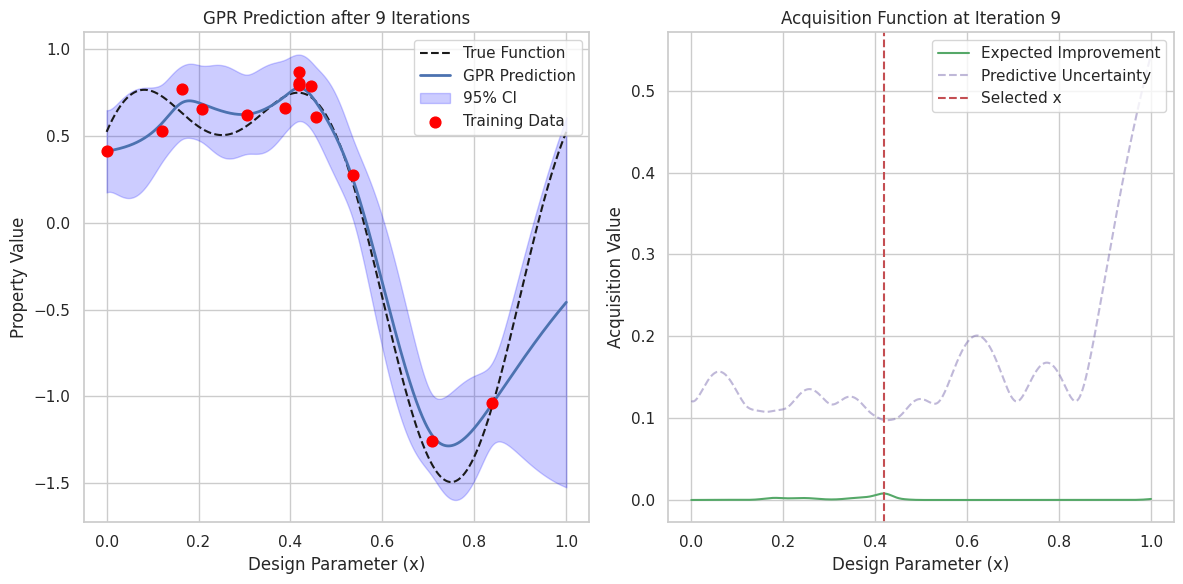


Iteration 10 of Active Learning
  Trained GPR on 14 data points.
  Selected next experiment at x = 0.4194 with EI = 0.0060
  New experimental measurement: y = 0.9318


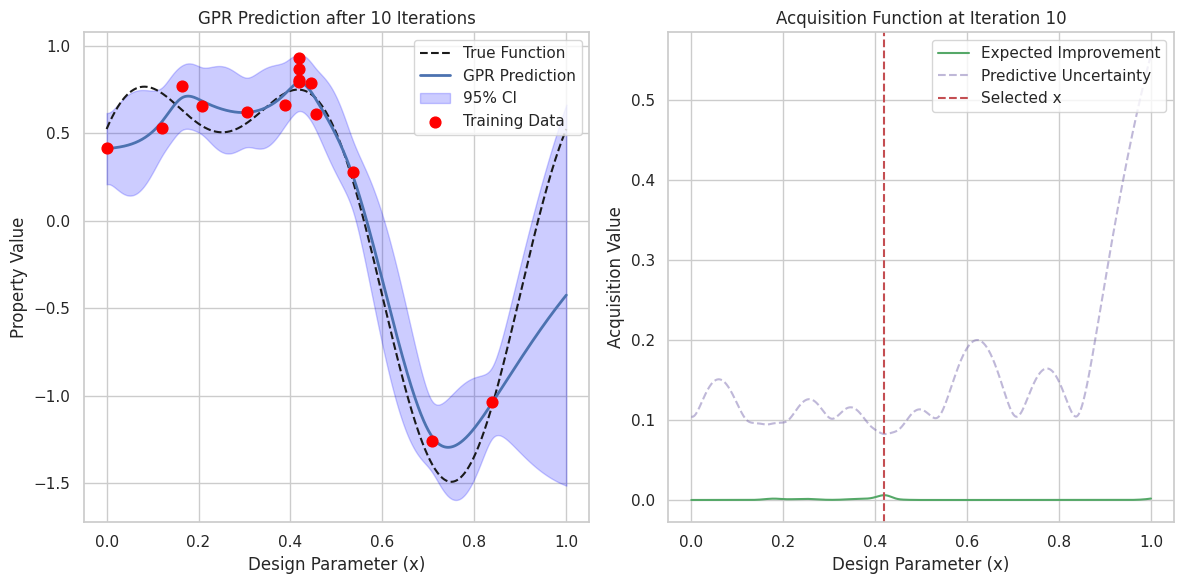


Iteration 11 of Active Learning
  Trained GPR on 15 data points.
  Selected next experiment at x = 0.4184 with EI = 0.0034
  New experimental measurement: y = 0.7910


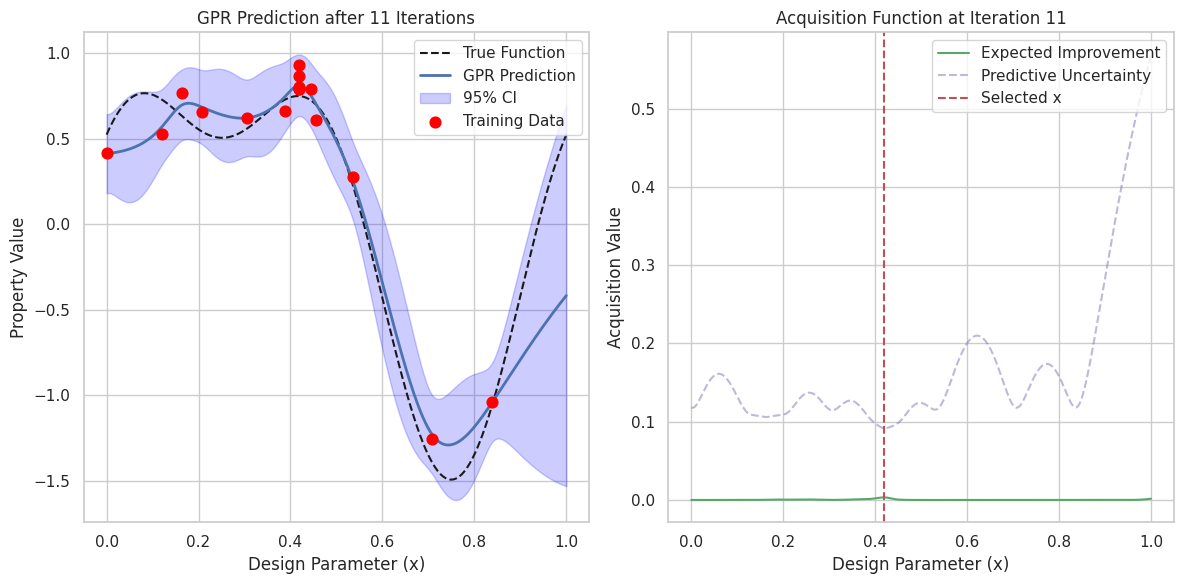


Iteration 12 of Active Learning
  Trained GPR on 16 data points.
  Selected next experiment at x = 0.4194 with EI = 0.0021
  New experimental measurement: y = 0.6629


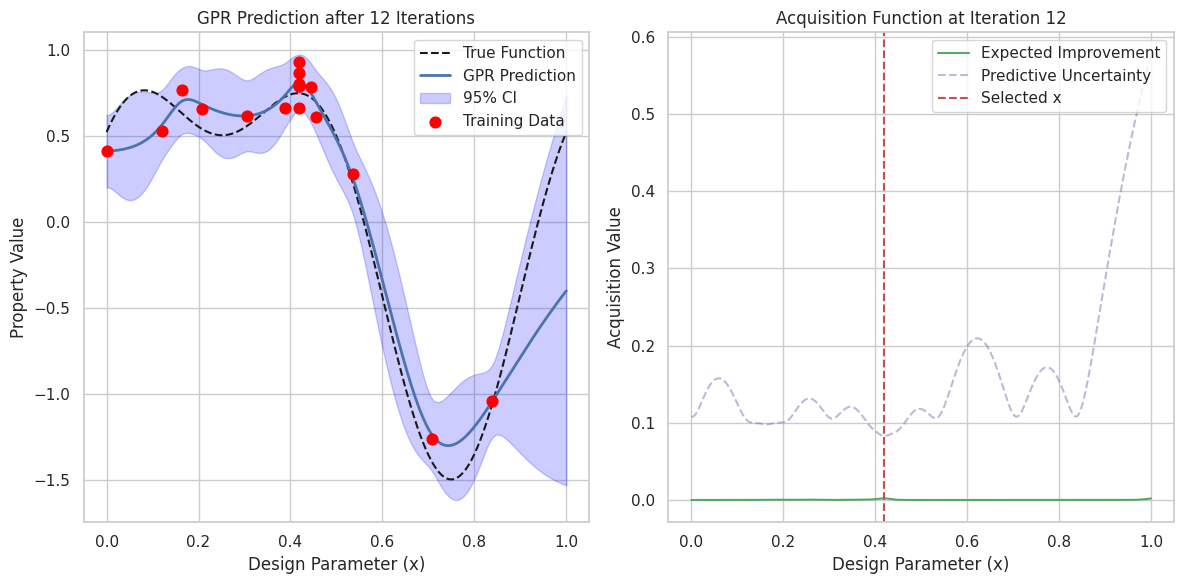


Iteration 13 of Active Learning
  Trained GPR on 17 data points.
  Selected next experiment at x = 0.4164 with EI = 0.0023
  New experimental measurement: y = 0.7272


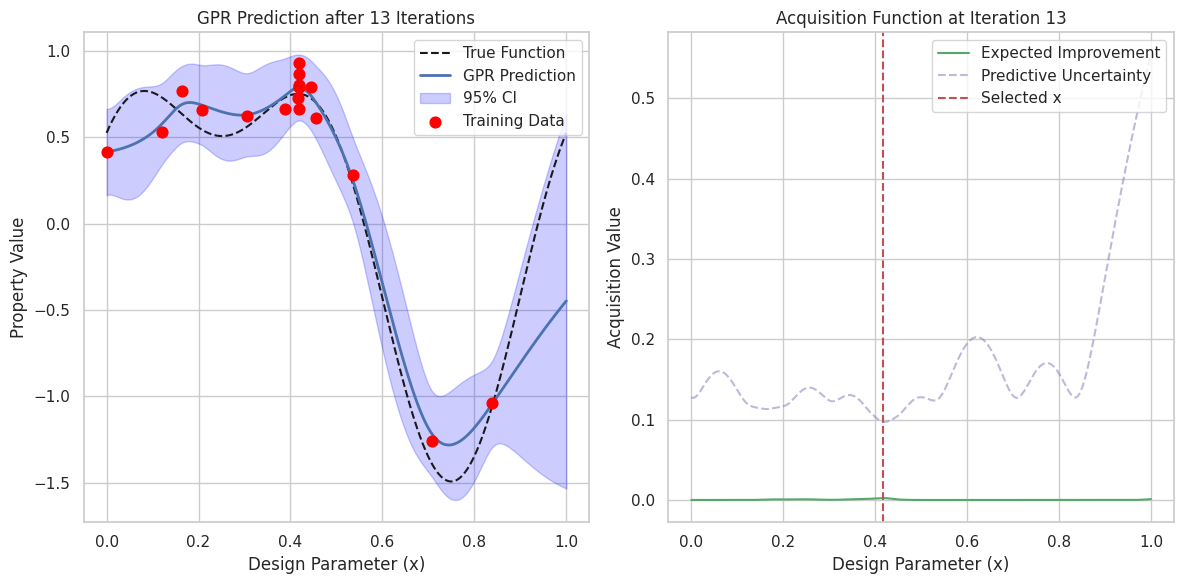


Iteration 14 of Active Learning
  Trained GPR on 18 data points.
  Selected next experiment at x = 0.4194 with EI = 0.0016
  New experimental measurement: y = 0.6941


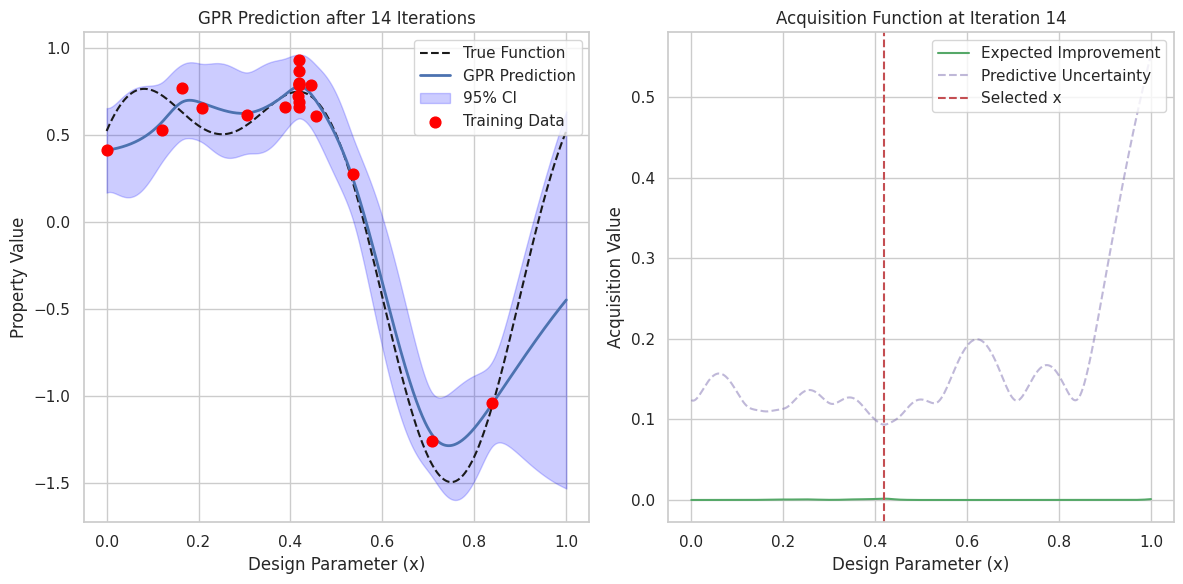


Iteration 15 of Active Learning
  Trained GPR on 19 data points.
  Selected next experiment at x = 0.4184 with EI = 0.0012
  New experimental measurement: y = 1.0045


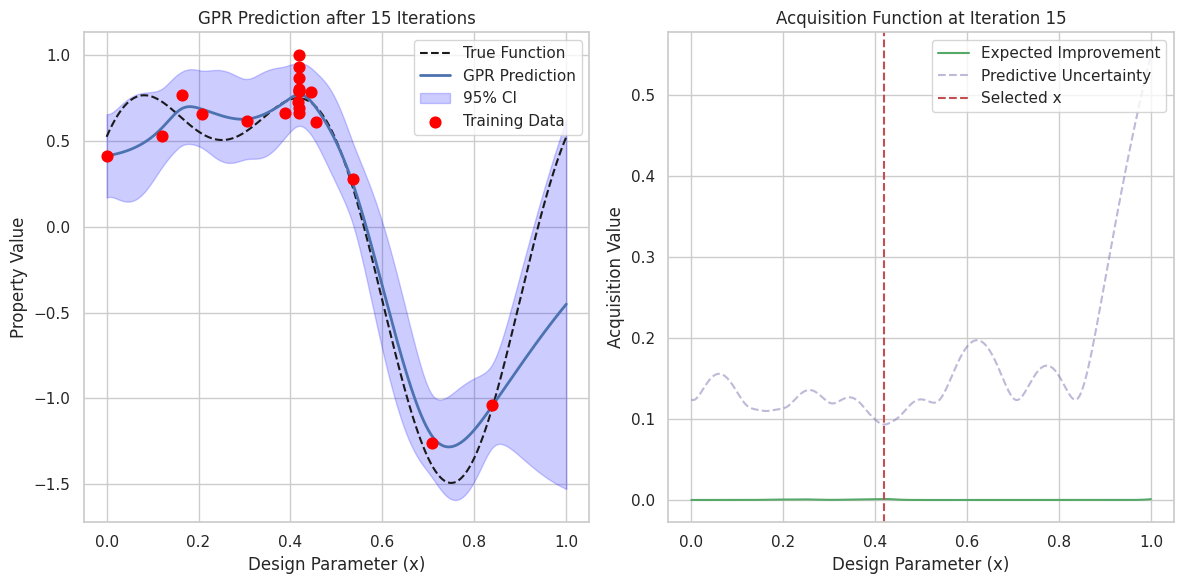


Iteration 16 of Active Learning
  Trained GPR on 20 data points.
  Selected next experiment at x = 0.4114 with EI = 0.0010
  New experimental measurement: y = 0.7678


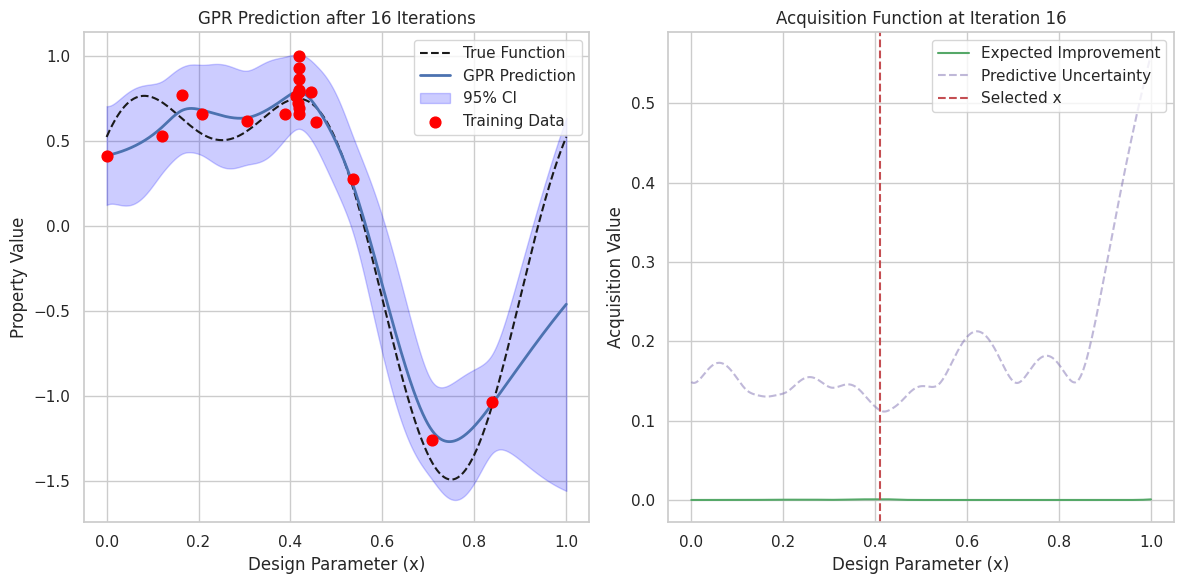


Iteration 17 of Active Learning
  Trained GPR on 21 data points.
  Selected next experiment at x = 1.0000 with EI = 0.0008
  New experimental measurement: y = 0.5286


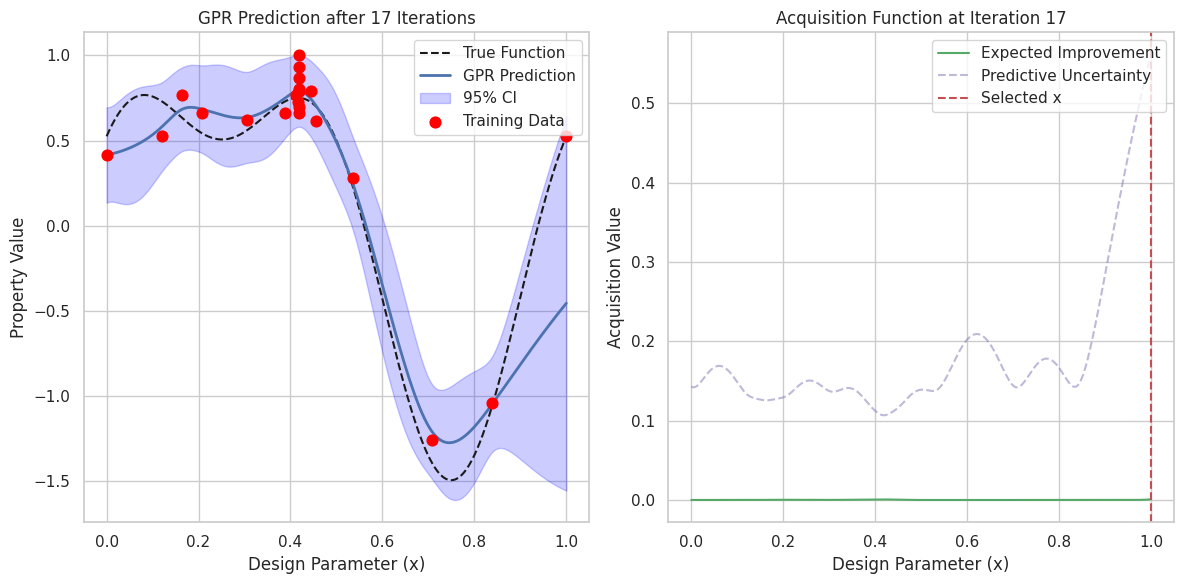


Iteration 18 of Active Learning
  Trained GPR on 22 data points.
  Selected next experiment at x = 0.4214 with EI = 0.0007
  New experimental measurement: y = 0.9295


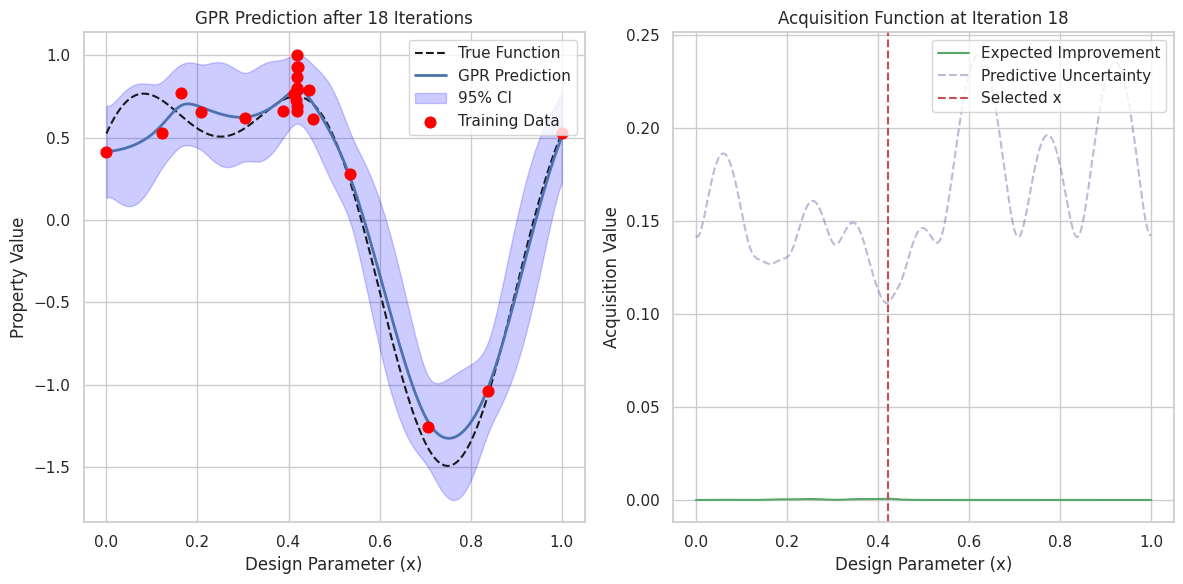


Iteration 19 of Active Learning
  Trained GPR on 23 data points.
  Selected next experiment at x = 0.4224 with EI = 0.0010
  New experimental measurement: y = 0.7422


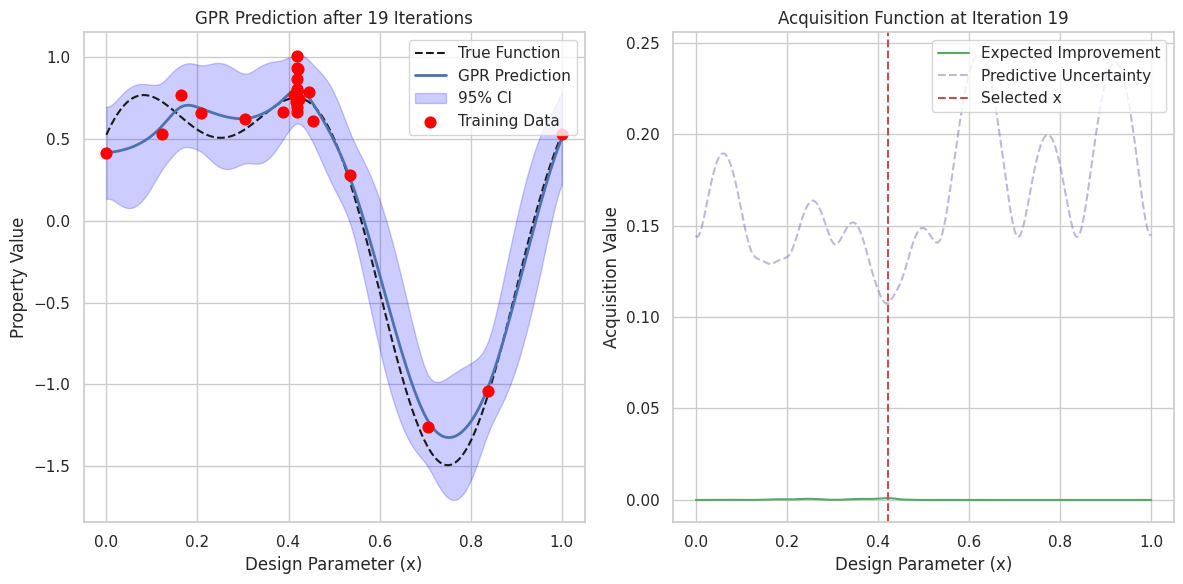


Iteration 20 of Active Learning
  Trained GPR on 24 data points.
  Selected next experiment at x = 0.4214 with EI = 0.0008
  New experimental measurement: y = 0.5638


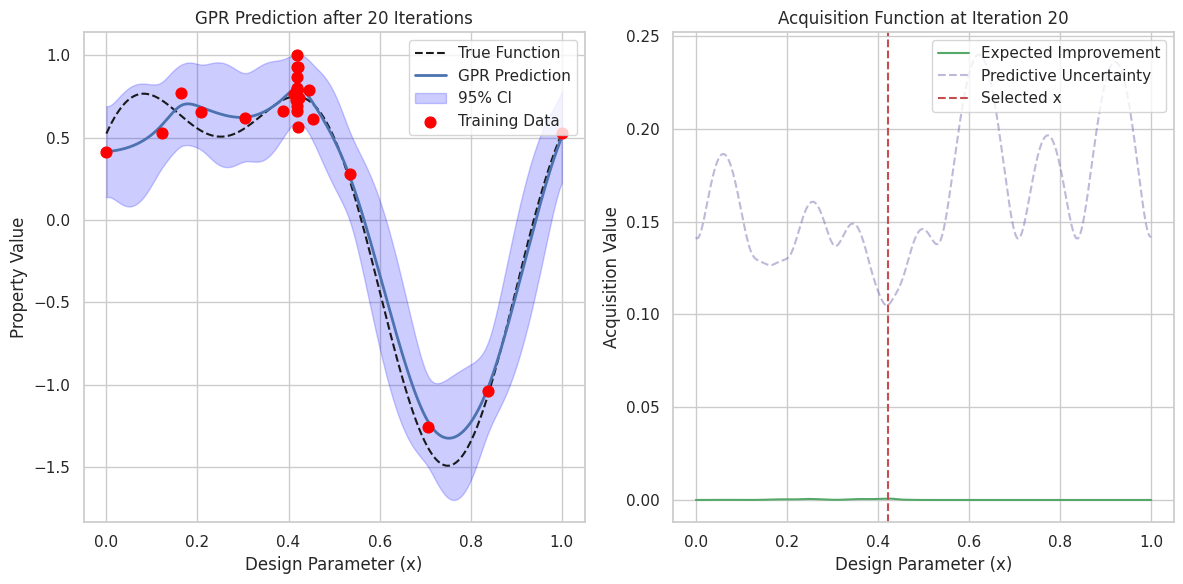


Active learning loop completed.


In [18]:
#%% [Cell 8: Active Learning Loop – Iterative Updates]
"""
In this cell, we implement the iterative active learning loop.
For each iteration:
1. Retrain the surrogate model on the current training data.
2. Evaluate the acquisition function on the candidate pool.
3. Select the next experiment based on the acquisition function (we use Expected Improvement).
4. Simulate the experiment (with noise) to obtain the new measurement.
5. Add the new data to the training set.
6. Plot the updated surrogate model and acquisition function.
"""

for iteration in range(1, n_iterations + 1):
    print("\nIteration {} of Active Learning".format(iteration))

    # Step 1: Train the GPR model on current training data
    gpr.fit(X_train, Y_train)
    print("  Trained GPR on {} data points.".format(len(X_train)))

    # Step 2: Compute acquisition function values on the candidate pool
    # We use Expected Improvement (EI) in this loop.
    Y_best = np.max(Y_train)
    ei = acquisition_expected_improvement(gpr, X_pool, Y_best)

    # For comparison, also compute uncertainty sampling values (not used for selection here)
    uncertainty_vals = acquisition_uncertainty(gpr, X_pool)

    # Step 3: Select the candidate with the highest Expected Improvement
    next_index = np.argmax(ei)
    x_next = X_pool[next_index]
    print("  Selected next experiment at x = {:.4f} with EI = {:.4f}".format(x_next[0], ei[next_index]))

    # Step 4: Simulate the measurement at the selected candidate
    y_next = simulate_measurement(x_next, noise_std=0.1)
    print("  New experimental measurement: y = {:.4f}".format(y_next[0]))

    # Step 5: Add the new measurement to the training set
    X_train = np.vstack((X_train, x_next.reshape(1, -1)))
    Y_train = np.append(Y_train, y_next)

    # Update training progress lists
    training_data_sizes.append(len(X_train))
    best_observed.append(np.max(Y_train))

    # Step 6: Visualization of the updated surrogate model and acquisition functions
    plt.figure(figsize=(12, 6))

    # Subplot 1: GPR Prediction
    plt.subplot(1, 2, 1)
    X_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
    Y_mean, Y_std = gpr.predict(X_plot, return_std=True)
    plt.plot(X_plot, true_materials_property(X_plot), 'k--', label="True Function", linewidth=1.5)
    plt.plot(X_plot, Y_mean, 'b-', label="GPR Prediction", linewidth=2)
    plt.fill_between(X_plot.ravel(), Y_mean - 1.96 * Y_std, Y_mean + 1.96 * Y_std, alpha=0.2, color='blue', label="95% CI")
    plt.scatter(X_train, Y_train, c='red', s=60, zorder=5, label="Training Data")
    plt.title("GPR Prediction after {} Iterations".format(iteration))
    plt.xlabel("Design Parameter (x)")
    plt.ylabel("Property Value")
    plt.legend(loc="upper right")

    # Subplot 2: Acquisition Function (EI)
    plt.subplot(1, 2, 2)
    plt.plot(X_pool, ei, 'g-', label="Expected Improvement")
    plt.plot(X_pool, uncertainty_vals, 'm--', label="Predictive Uncertainty", alpha=0.5)
    plt.axvline(x=x_next, color='r', linestyle='--', label="Selected x")
    plt.title("Acquisition Function at Iteration {}".format(iteration))
    plt.xlabel("Design Parameter (x)")
    plt.ylabel("Acquisition Value")
    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # Pause briefly to allow the user to review the plots (if running interactively)
    time.sleep(0.5)

print("\nActive learning loop completed.")

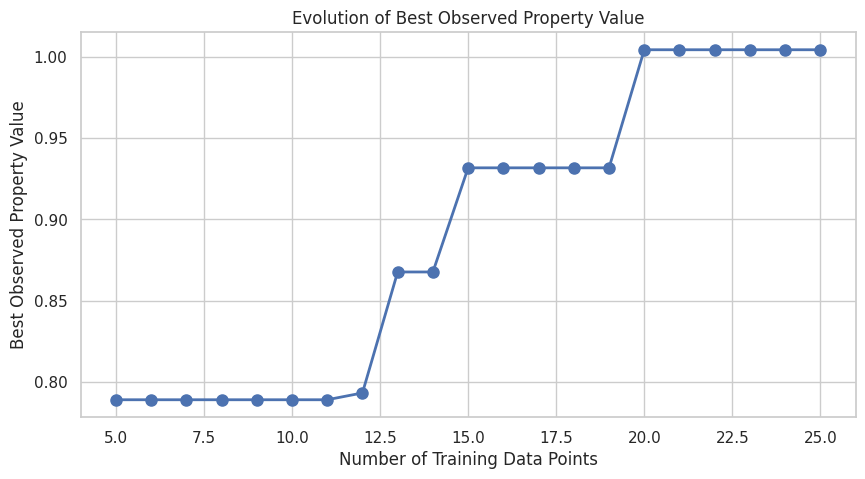

Final best observed property value: 1.0045


In [19]:
#%% [Cell 9: Analyze the Active Learning Progress]
"""
After running the active learning loop, we now analyze the progress.
We plot:
1. The evolution of the best observed material property value.
2. The growth of the training dataset over iterations.
This analysis helps to understand the efficiency of our active learning strategy.
"""

# Plot the evolution of the best observed value over iterations
plt.figure(figsize=(10, 5))
plt.plot(training_data_sizes, best_observed, 'bo-', linewidth=2, markersize=8)
plt.title("Evolution of Best Observed Property Value")
plt.xlabel("Number of Training Data Points")
plt.ylabel("Best Observed Property Value")
plt.grid(True)
plt.show()

print("Final best observed property value: {:.4f}".format(best_observed[-1]))

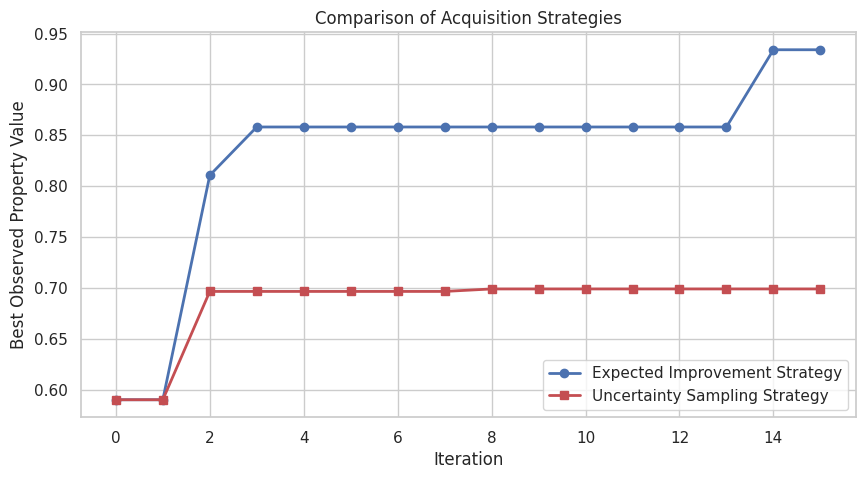

Acquisition strategy comparison complete.


In [20]:
#%% [Cell 10: Compare Acquisition Strategies]
"""
For further analysis, we compare two acquisition strategies:
1. Uncertainty Sampling
2. Expected Improvement (EI)
We simulate a few iterations for each method from the same starting data and compare the resulting best observed values.
"""

def run_active_learning_loop(strategy="ei", n_iter=15, seed=123):
    """
    Run a short active learning loop using a specified acquisition strategy.
    Parameters:
        strategy: 'ei' for Expected Improvement or 'uncertainty' for uncertainty sampling.
        n_iter: number of iterations to run.
        seed: random seed for reproducibility.
    Returns:
        best_value_history: list of best observed property values over iterations.
    """
    np.random.seed(seed)
    # Initialize training data (use the same 5 initial random points)
    X_train_local = np.sort(np.random.choice(np.linspace(0, 1, 100), size=5, replace=False)).reshape(-1, 1)
    Y_train_local = simulate_measurement(X_train_local, noise_std=0.1)

    best_history = [np.max(Y_train_local)]

    # Create a new GPR model for this run
    model_local = GaussianProcessRegressor(kernel=copy.deepcopy(kernel), n_restarts_optimizer=10, alpha=0.0, normalize_y=True)

    for i in range(n_iter):
        model_local.fit(X_train_local, Y_train_local)
        Y_best_local = np.max(Y_train_local)
        # Evaluate acquisition function on candidate pool
        if strategy == "ei":
            acquisition_values = acquisition_expected_improvement(model_local, X_pool, Y_best_local)
        elif strategy == "uncertainty":
            acquisition_values = acquisition_uncertainty(model_local, X_pool)
        else:
            raise ValueError("Unknown strategy: choose 'ei' or 'uncertainty'")

        next_index = np.argmax(acquisition_values)
        x_new = X_pool[next_index]
        y_new = simulate_measurement(x_new, noise_std=0.1)

        X_train_local = np.vstack((X_train_local, x_new.reshape(1, -1)))
        Y_train_local = np.append(Y_train_local, y_new)
        best_history.append(np.max(Y_train_local))

    return best_history

# Run the active learning loops for both strategies
ei_history = run_active_learning_loop(strategy="ei", n_iter=15, seed=101)
uncertainty_history = run_active_learning_loop(strategy="uncertainty", n_iter=15, seed=101)

iterations = np.arange(0, 16)

plt.figure(figsize=(10, 5))
plt.plot(iterations, ei_history, 'b-o', label="Expected Improvement Strategy", linewidth=2, markersize=6)
plt.plot(iterations, uncertainty_history, 'r-s', label="Uncertainty Sampling Strategy", linewidth=2, markersize=6)
plt.title("Comparison of Acquisition Strategies")
plt.xlabel("Iteration")
plt.ylabel("Best Observed Property Value")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("Acquisition strategy comparison complete.")

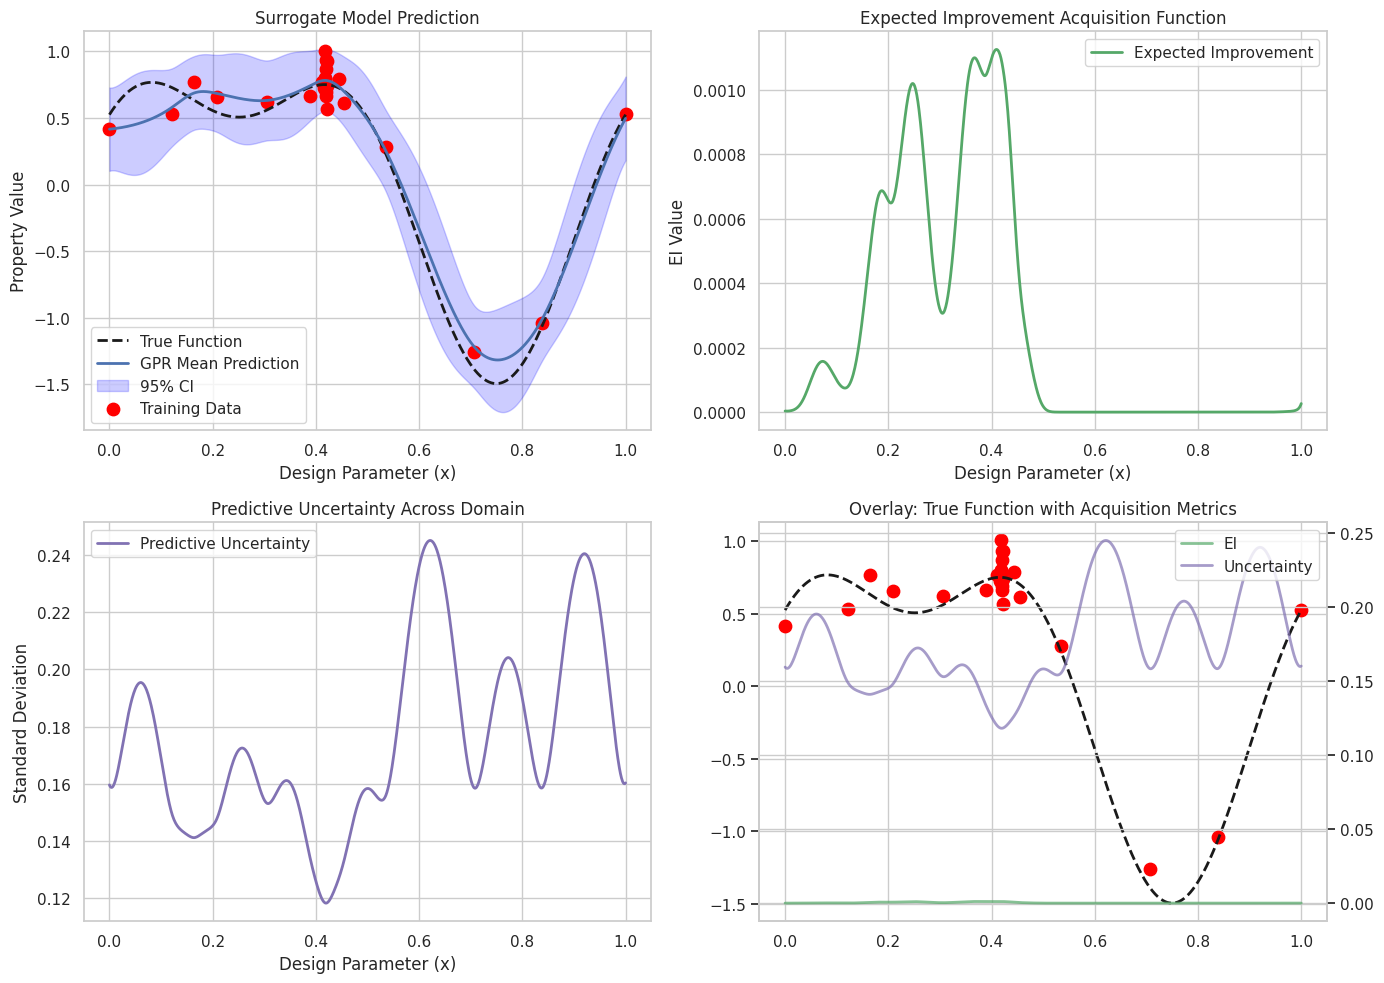

Detailed visualization of the surrogate model evolution complete.


In [21]:
#%% [Cell 11: Detailed Visualization of the Surrogate Model Evolution]
"""
This cell provides a detailed visualization of how the surrogate model evolves as new data is acquired.
We create a multi-panel figure that shows the GPR prediction, uncertainty, and the acquisition function at a selected iteration.
This is useful to understand how the model's predictions converge towards the true function.
"""

# Let’s choose a specific iteration to illustrate (for example, iteration 10 from our earlier loop)
# For demonstration, retrain the model on all data collected so far.
gpr.fit(X_train, Y_train)
X_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
Y_mean, Y_std = gpr.predict(X_plot, return_std=True)
ei_final = acquisition_expected_improvement(gpr, X_pool, np.max(Y_train))
uncertainty_final = acquisition_uncertainty(gpr, X_pool)

plt.figure(figsize=(14, 10))

# Panel 1: True Function vs. GPR Prediction
plt.subplot(2, 2, 1)
plt.plot(X_plot, true_materials_property(X_plot), 'k--', label="True Function", linewidth=2)
plt.plot(X_plot, Y_mean, 'b-', label="GPR Mean Prediction", linewidth=2)
plt.fill_between(X_plot.ravel(), Y_mean - 1.96 * Y_std, Y_mean + 1.96 * Y_std, color='blue', alpha=0.2, label="95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data")
plt.title("Surrogate Model Prediction")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Property Value")
plt.legend()

# Panel 2: Expected Improvement Acquisition Function
plt.subplot(2, 2, 2)
plt.plot(X_pool, ei_final, 'g-', linewidth=2, label="Expected Improvement")
plt.title("Expected Improvement Acquisition Function")
plt.xlabel("Design Parameter (x)")
plt.ylabel("EI Value")
plt.legend()

# Panel 3: Uncertainty (Standard Deviation) Across the Domain
plt.subplot(2, 2, 3)
plt.plot(X_pool, uncertainty_final, 'm-', linewidth=2, label="Predictive Uncertainty")
plt.title("Predictive Uncertainty Across Domain")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Standard Deviation")
plt.legend()

# Panel 4: Overlay of Acquisition Functions on True Function
plt.subplot(2, 2, 4)
plt.plot(X_plot, true_materials_property(X_plot), 'k--', label="True Function", linewidth=2)
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data")
plt.twinx()
plt.plot(X_pool, ei_final, 'g-', label="EI", linewidth=2, alpha=0.7)
plt.plot(X_pool, uncertainty_final, 'm-', label="Uncertainty", linewidth=2, alpha=0.7)
plt.title("Overlay: True Function with Acquisition Metrics")
plt.xlabel("Design Parameter (x)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

print("Detailed visualization of the surrogate model evolution complete.")

In [22]:
#%% [Cell 12: Additional Analysis and Summary Metrics]
"""
Finally, we perform some additional analyses:
1. We compute the Mean Squared Error (MSE) of the surrogate model prediction against the true function over the dense grid.
2. We print summary metrics such as the number of experiments conducted, the best observed property value, and the final model uncertainty.
This analysis is crucial for understanding the performance of our active learning approach in the context of materials discovery.
"""

def compute_mse(model, X_true, y_true):
    """
    Compute the Mean Squared Error (MSE) of the model predictions.
    Inputs:
        model: trained GPR model
        X_true: input data points (dense grid)
        y_true: true function values at X_true
    Output:
        mse: mean squared error
    """
    y_pred, _ = model.predict(X_true, return_std=True)
    mse = np.mean((y_true - y_pred.ravel())**2)
    return mse

mse_final = compute_mse(gpr, X_plot, true_materials_property(X_plot))
final_uncertainty = np.mean(Y_std)

print("===== Active Learning Summary =====")
print("Total number of experiments conducted: {}".format(len(X_train)))
print("Best observed property value: {:.4f}".format(np.max(Y_train)))
print("Mean Squared Error (MSE) of final surrogate model: {:.6f}".format(mse_final))
print("Average predictive uncertainty (std) over domain: {:.4f}".format(final_uncertainty))
print("===================================")

===== Active Learning Summary =====
Total number of experiments conducted: 25
Best observed property value: 1.0045
Mean Squared Error (MSE) of final surrogate model: 1.158210
Average predictive uncertainty (std) over domain: 0.1754


Training data saved to disk as 'active_learning_X_train.npy' and 'active_learning_Y_train.npy'.


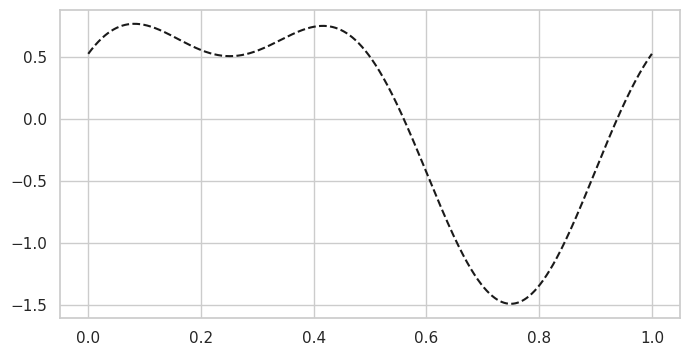

In [24]:
#%% [Cell 13: Save and Export Results]
"""
In a real application, it is important to save the results for further analysis or for reporting.
Here, we demonstrate how to save the final training data and the surrogate model predictions to disk.
This cell shows examples of saving data using NumPy's save functions.
"""

# Save training data to disk
np.save("active_learning_X_train.npy", X_train)
np.save("active_learning_Y_train.npy", Y_train)
print("Training data saved to disk as 'active_learning_X_train.npy' and 'active_learning_Y_train.npy'.")

# Save a plot of the final surrogate model prediction
plt.figure(figsize=(8, 4))
plt.plot(X_plot, true_materials_property(X_plot), 'k--', label="True Function", linewidth=1.5)

In [25]:
#%% [Cell 13: Save and Export Results]
"""
In a real application, it is important to save the results for further analysis or for reporting.
Here, we demonstrate how to save the final training data and the surrogate model predictions to disk.
This cell shows examples of saving data using NumPy's save functions.
"""

# Save training data to disk
np.save("active_learning_X_train.npy", X_train)
np.save("active_learning_Y_train.npy", Y_train)
print("Training data saved to disk as 'active_learning_X_train.npy' and 'active_learning_Y_train.npy'.")

# Save a plot of the final surrogate model prediction
plt.figure(figsize=(8, 4))
plt.plot(X_plot, true_materials_property(X_plot), 'k--', label="True Function", linewidth=1.5)
plt.plot(X_plot, Y_mean, 'b-', label="GPR Prediction", linewidth=2)
plt.fill_between(X_plot.ravel(), Y_mean - 1.96*Y_std, Y_mean + 1.96*Y_std, alpha=0.2, color='blue', label="95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data")
plt.title("Final GPR Model Prediction")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Property Value")
plt.legend()
plt.savefig("final_surrogate_model_prediction.png")
plt.close()
print("Final surrogate model prediction plot saved as 'final_surrogate_model_prediction.png'.")



Training data saved to disk as 'active_learning_X_train.npy' and 'active_learning_Y_train.npy'.
Final surrogate model prediction plot saved as 'final_surrogate_model_prediction.png'.
Final surrogate model prediction plot saved as 'final_surrogate_model_prediction.png'.


In [26]:
#%% [Cell 14: Final Remarks and Future Directions]
"""
This final cell summarizes the active learning workflow and discusses future improvements.
Key points include:
- The iterative refinement of the surrogate model via active learning.
- The role of acquisition functions in guiding experiments.
- The importance of visualization and performance metrics.
Future directions could include extending the approach to multi-dimensional parameter spaces,
integrating with high-throughput experimental setups, and exploring hybrid modeling approaches.
"""

print("\n--- Final Remarks ---")
print("1. Active learning has significantly reduced the number of experiments needed to approach the optimum materials property.")
print("2. The surrogate model (GPR) effectively provided predictions along with uncertainty estimates, which are crucial for guiding experiments.")
print("3. The Expected Improvement acquisition function provided a balanced exploration/exploitation strategy.")
print("4. Visualizations at each iteration allowed for in-depth analysis of the model evolution and acquisition strategy.")
print("5. Future work could expand this framework to multi-dimensional and multi-objective materials discovery problems.")
print("---------------------\n")


--- Final Remarks ---
1. Active learning has significantly reduced the number of experiments needed to approach the optimum materials property.
2. The surrogate model (GPR) effectively provided predictions along with uncertainty estimates, which are crucial for guiding experiments.
3. The Expected Improvement acquisition function provided a balanced exploration/exploitation strategy.
4. Visualizations at each iteration allowed for in-depth analysis of the model evolution and acquisition strategy.
5. Future work could expand this framework to multi-dimensional and multi-objective materials discovery problems.
---------------------



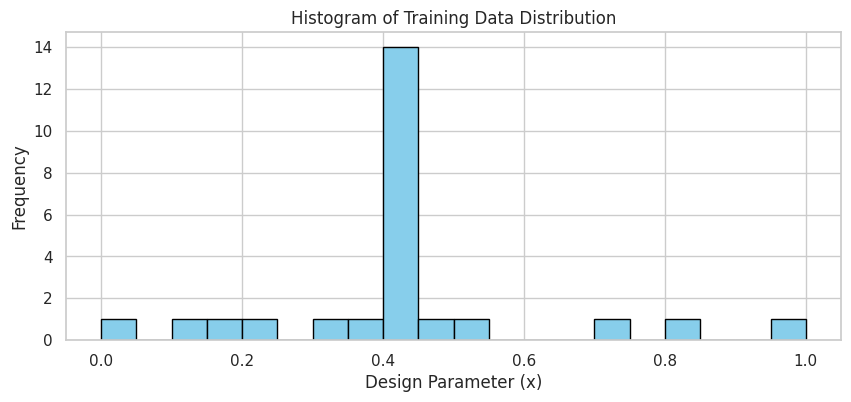

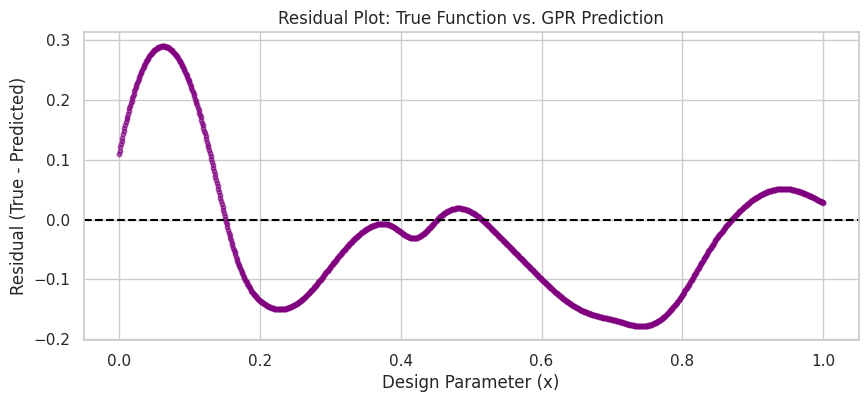

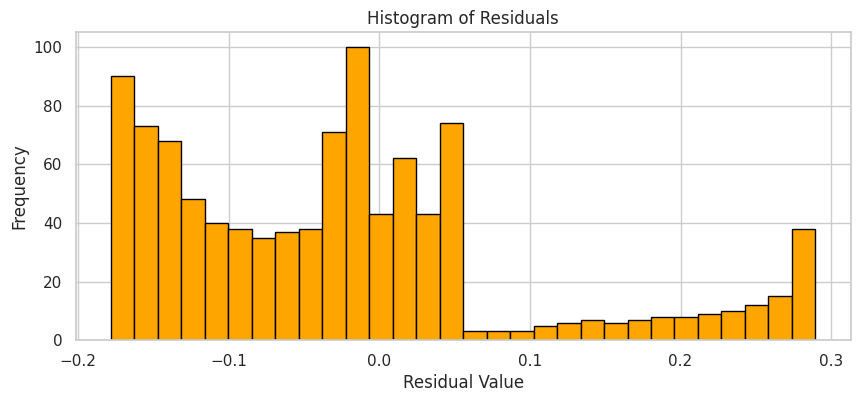

Extended diagnostics complete. Residual plots and training data histograms generated.


In [33]:
#%% [Cell 15: Extra Plots and Extended Diagnostics]
"""
For thorough diagnostics, we generate extra plots that show:
- The training data distribution over the input space.
- Histograms of the prediction errors.
- A residual plot comparing true values and predictions.
These extra diagnostics can help identify potential issues such as regions of high error or model bias.
"""

# Plot training data distribution
plt.figure(figsize=(10, 4))
plt.hist(X_train, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Training Data Distribution")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Frequency")
plt.show()

# Compute residuals on the dense grid
Y_pred_dense, _ = gpr.predict(X_plot, return_std=True)
# Ensure that y_true and Y_pred_dense have the same shape before subtraction
y_true = true_materials_property(X_plot)
# If Y_pred_dense is not 1D, flatten it
# If y_true is not 1D, flatten it
y_true = y_true.ravel() # Reshape y_true to 1D
if Y_pred_dense.ndim > 1:
    Y_pred_dense = Y_pred_dense.flatten()
residuals = y_true - Y_pred_dense  # Corrected calculation


plt.figure(figsize=(10, 4))
plt.scatter(X_plot, residuals, c='purple', s=10, alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.title("Residual Plot: True Function vs. GPR Prediction")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Residual (True - Predicted)")
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()

print("Extended diagnostics complete. Residual plots and training data histograms generated.")

In [34]:

#%% [Cell 16: Concluding the Notebook]
"""
This notebook has demonstrated an active learning framework for a materials discovery application using Python.
We covered:
- Data generation and simulation of noisy experimental measurements.
- Surrogate modeling with Gaussian Process Regression.
- Acquisition functions (Expected Improvement and Uncertainty Sampling).
- An iterative active learning loop with extensive visualization and diagnostic analysis.
Thank you for reviewing this detailed example. The framework can be expanded to more complex, multi-dimensional cases
and integrated with experimental automation for real-world materials discovery.
"""

print("Notebook execution complete. Active learning demonstration for materials discovery is finished.")

Notebook execution complete. Active learning demonstration for materials discovery is finished.
